# 3. Solving Differential Equations with the Shooting Method
## B. The Radial Function

### Where we left off

We were able to solve for $S(\eta)$ of $\psi(\xi, \eta, \phi)=R(\xi)S(\eta)\Phi(\phi)$ for various values of $c^2$. In the process, we were also able to express $\Lambda$ as a fourth-degree polynomial of $c^2$. This was a particularly important achievement as this $\Lambda$ is also present in the differential equation for the radial equation $R(\eta)$. 

$$ \frac{d }{d \xi}\left [ \left ( \xi^2 - 1 \right ) \frac{d R}{d \xi} \right ] + \left [ 2D\xi + c^2 \xi^2 -\frac{\mu^2}{\xi^2 - 1} - \Lambda\left ( c^2 \right ) \right ]R = 0$$

Just like for $S(\eta)$, the function $R(\xi)$ can be expressed with another function $g(\xi)$ in the following way.

$$R(\xi)=\left ( \xi^2 - 1 \right ) ^{\mu/2} g(\xi)$$

Substituting yields

$$\left ( \xi^2 -1 \right ) g'' + 2\left ( \mu + 1 \right ) \xi \, g' + \left [2 D \xi +c^2 \xi^2 + \mu \left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )  \right ] g = 0$$

Note that as $c^2=\frac{1}{4}ED^2$, $c^2$ is dependent on $E$. Thus, with this differential equation, we intend to find values for $E$ which results in approprite $g(\xi)$s.

### Conditions on the function $g(\xi)$

Similar to $f(\eta)$, we let $g(1)=1$ and obtain $g'(1)$ from the limiting form of the equation above when $\xi \to 1+$.

$$g'(1)=-\frac{2D + c^2 + \mu\left ( \mu + 1 \right ) - \Lambda\left ( c^2 \right )}{2 \left ( \mu + 1 \right )}$$

The constraint for $f(\eta)$ was $f(0)=0$ or $f'(0)=0$ depending on the symmetry. The constraint for $g(\xi)$ is derived from the fact that the HMI is a bound state. Recall that for atomic orbitals, as $r \to \infty$, $\psi \to 0$. Thus, for the HMI, as $\xi \to \infty$, $\psi \to 0$. An actually implementable constraint is something like $g(\xi_{cutoff})=0$ where $\xi_{cutoff} \approx 10$. For $\xi > \xi_{cutoff}$, $g(\xi)=0$, thus $R(\xi)=0$. 

### The shooting method for $g(\xi)$

For this example, $\mu = 0$, $l = 0$, and $D = 2$.

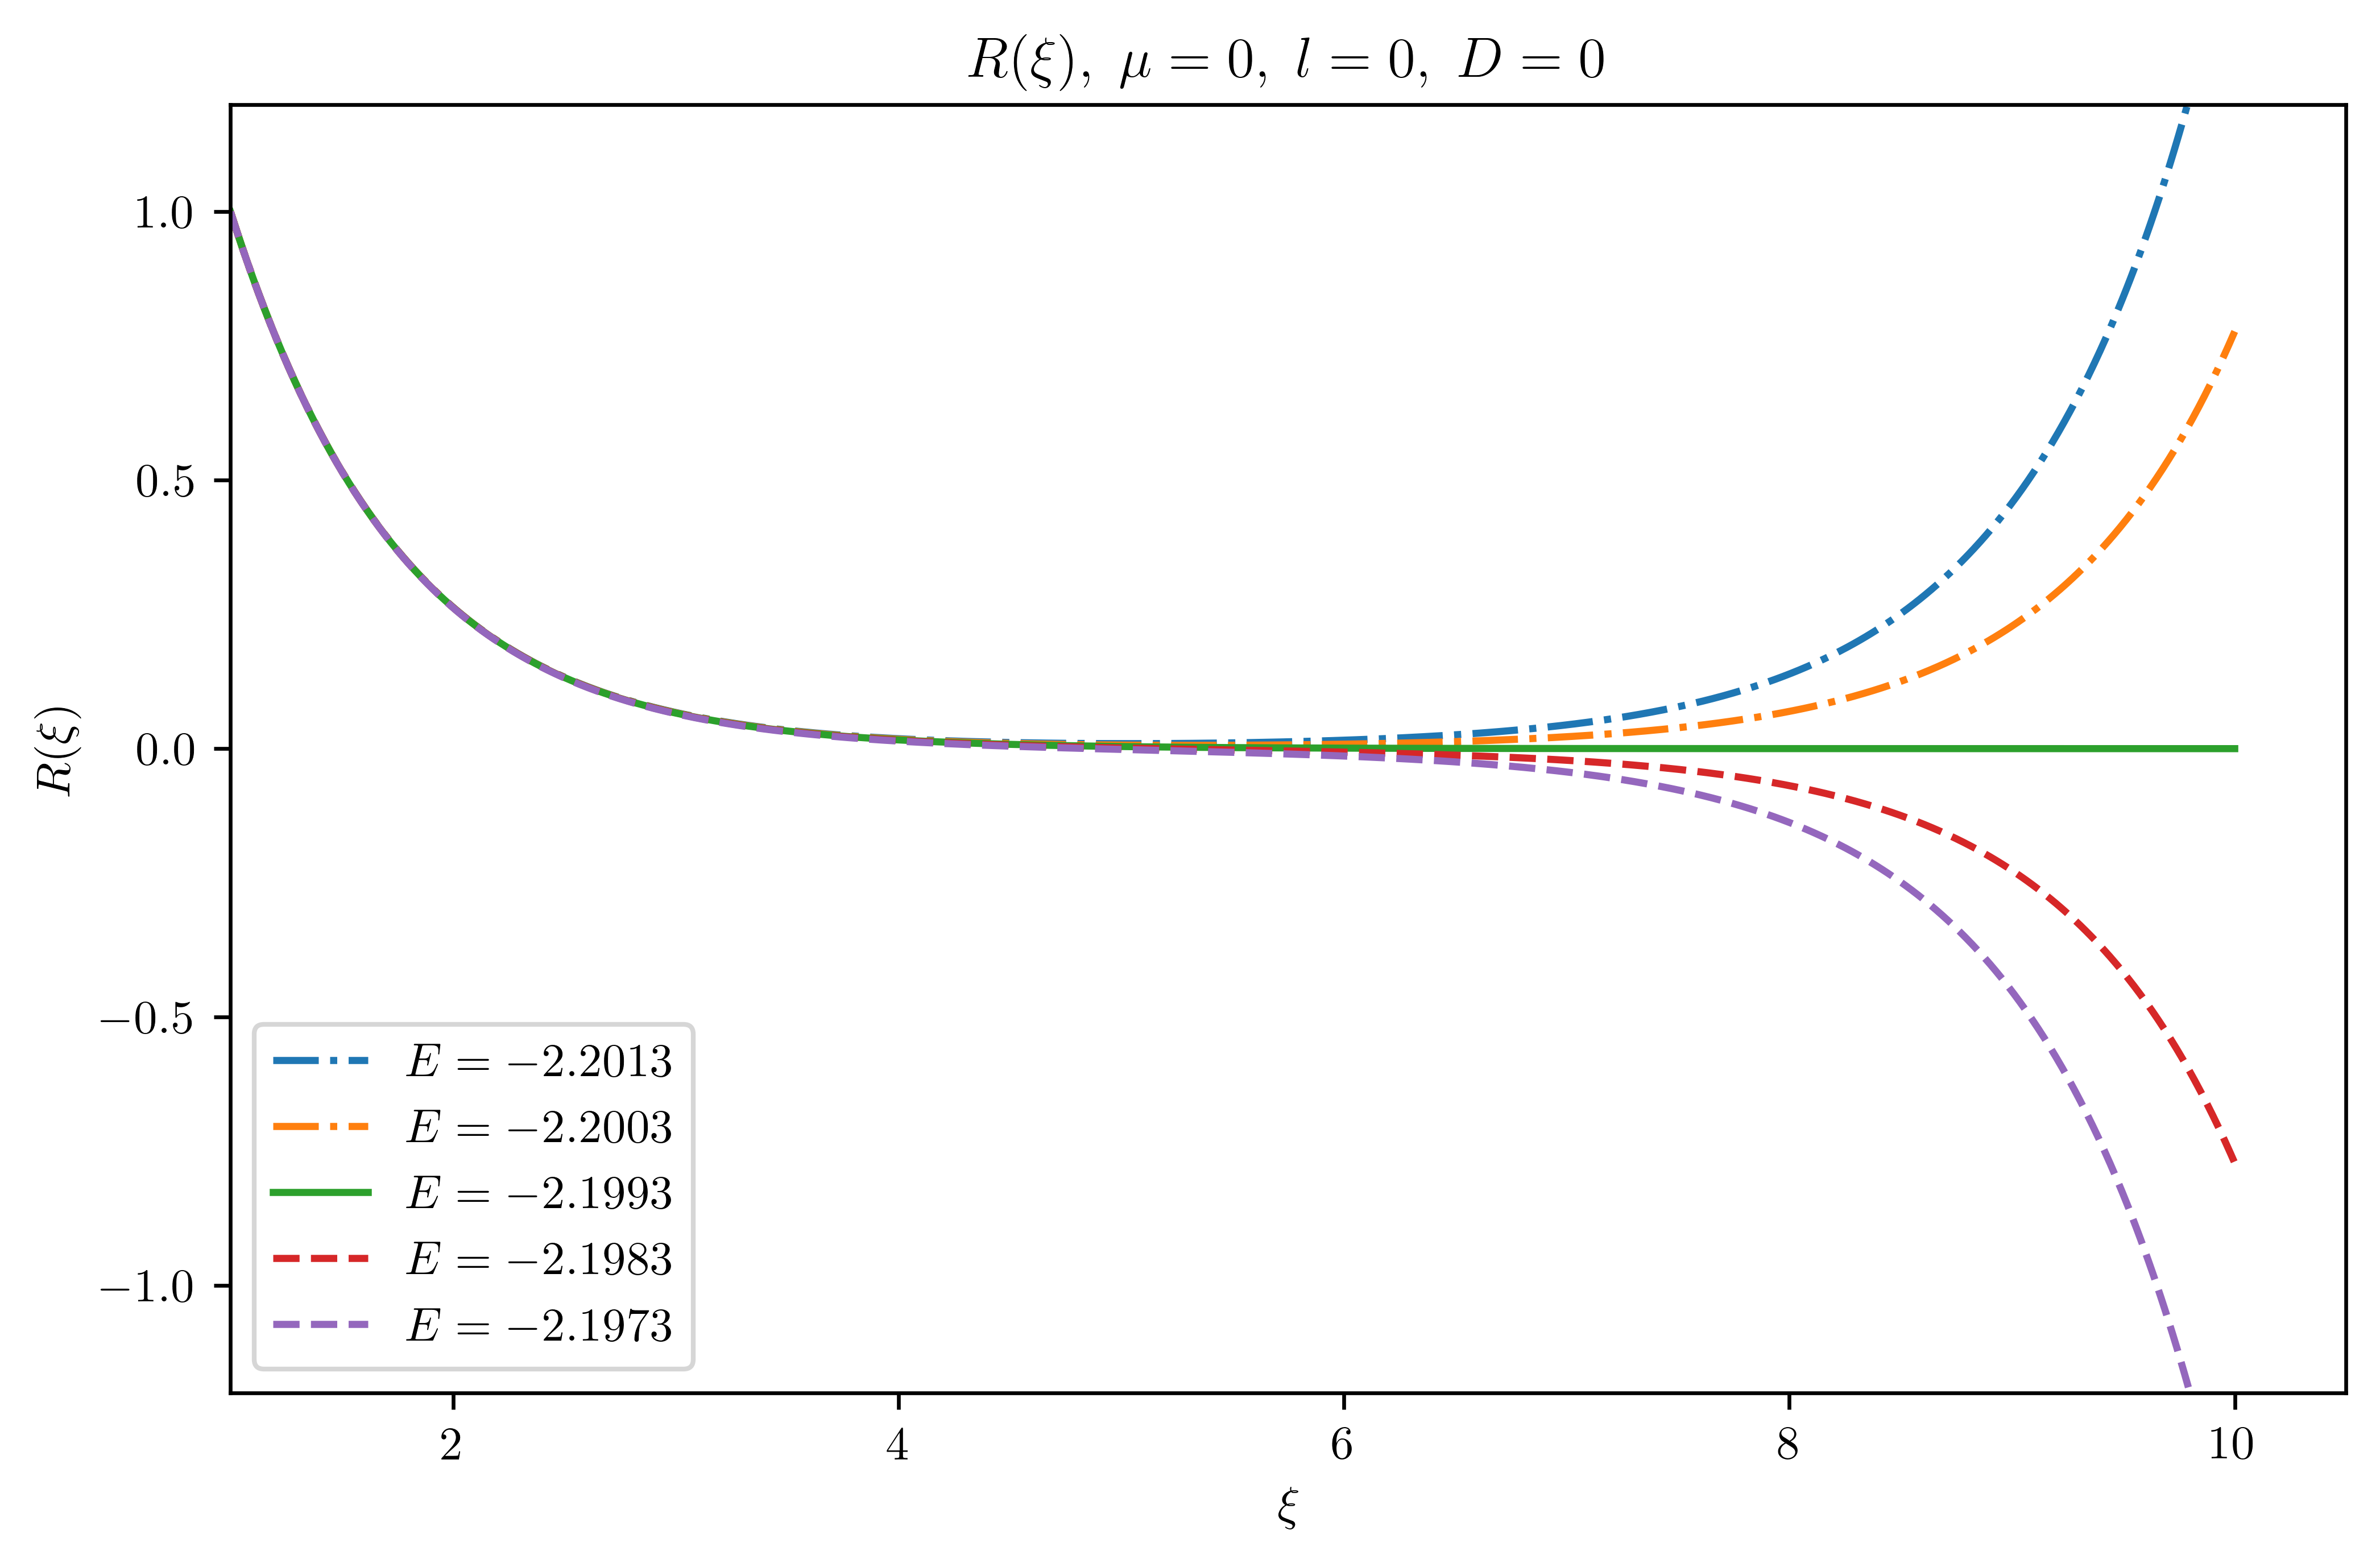

In [1]:
import numpy as np
from numpy import polynomial as P 
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.figsize": [8.0, 5.0]})

try:
    # this may look good for retina display users
    %config InlineBackend.figure_format = 'retina'
except:
    pass

# lambdas we calculated before
def get_lbda(mu, l):
    # only for cases l <= 2
    # lambdas we calculated before
    import os
    filename = f"data_lbda/lbda_{mu}{l}.txt"
    filedir = os.path.join(os.path.abspath(''), filename)
    lbda_coef = None
    with open(filedir, 'r') as file:
        lbda_coef = np.loadtxt(file)
    return P.Polynomial(lbda_coef)

# mu, l, as declared above
mu = 0
l = 0
D = 2
lbda = get_lbda(mu, l)

# for a given E_val, solve R(xi)
# also used to calculate g(10) for optimization
def calculate_R(mu, l, E_val, lbda, cutoff=10, g10_instead=False):
    c2 = (1/4) * E_val * (D**2)

    # initial value of g and g'
    q1 = np.array([1,-(2*D + c2 + mu*(mu+1) - lbda(c2))/(2*(mu+1))])
    
    G = lambda xi, q: np.array([[0, 1],
    [-(2*D*xi + c2*(xi**2) + mu*(mu+1) - lbda(c2))/(xi**2 - 1),
    -(2*(mu+1)*xi)/(xi**2 - 1)]]) @ q
    
    # solve for g(xi) for 1 < xi <= 10
    # exclude xi = 1 to avoid a divide-by-zero error
    xi_span_for_calc = np.linspace(1, cutoff, cutoff*100)
    eps = 1e-10
    xi_span_for_calc[0] = 1 + eps
    
    sol = solve_ivp(G, [1 + eps, cutoff], q1, t_eval=xi_span_for_calc)
    
    # for optimization only
    if g10_instead:
        return sol.y[0][-1]
    
    # calculate R from g
    R_vals = ((xi_span_for_calc ** 2 - 1)**(mu/2)) * sol.y[0]
    
    # add back R(xi) = 0 or 1 depending on mu
    R_vals[0] = 1 if mu == 0 else 0
    
    return R_vals

# use shooting method to solve
cutoff = 10
E_val_guess = -2.2
objective = np.vectorize(lambda E: calculate_R(mu, l, E, lbda, cutoff=cutoff, g10_instead=True))
E_val_final, = fsolve(objective, E_val_guess)

# evaluate R_vals of E_val_final -0.2, 0, +0.2
E_vals = np.array([-0.002, -0.001, 0, 0.001, 0.002]) + E_val_final

fig, ax = plt.subplots()

lss = ["-.", "-.","-" , "--", "--"]

xi_span = np.linspace(1, cutoff, cutoff*100)

for ind, E_val in enumerate(E_vals):
    R_vals = calculate_R(mu, l, E_val, lbda)
    E_val_label = f'$E = {E_val:.4f}$'
    ax.plot(xi_span, R_vals, label=E_val_label, ls=lss[ind])
ax.set_title(r'$R(\xi), \; \mu = 0, \; l = 0, \; D = 0$')
ax.legend()
ax.set_ylim(-1.2, 1.2)
ax.set_xlim(1, 10.5)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

Note that with different initial guesses of $E$, a different $R(\xi)$ of the same $\mu, l$, and $D$ can be also be calculated. Note that for $R(\xi)$ of higher $E$, we need to use a greater $\xi_{cutoff}$ to attain accurate results.

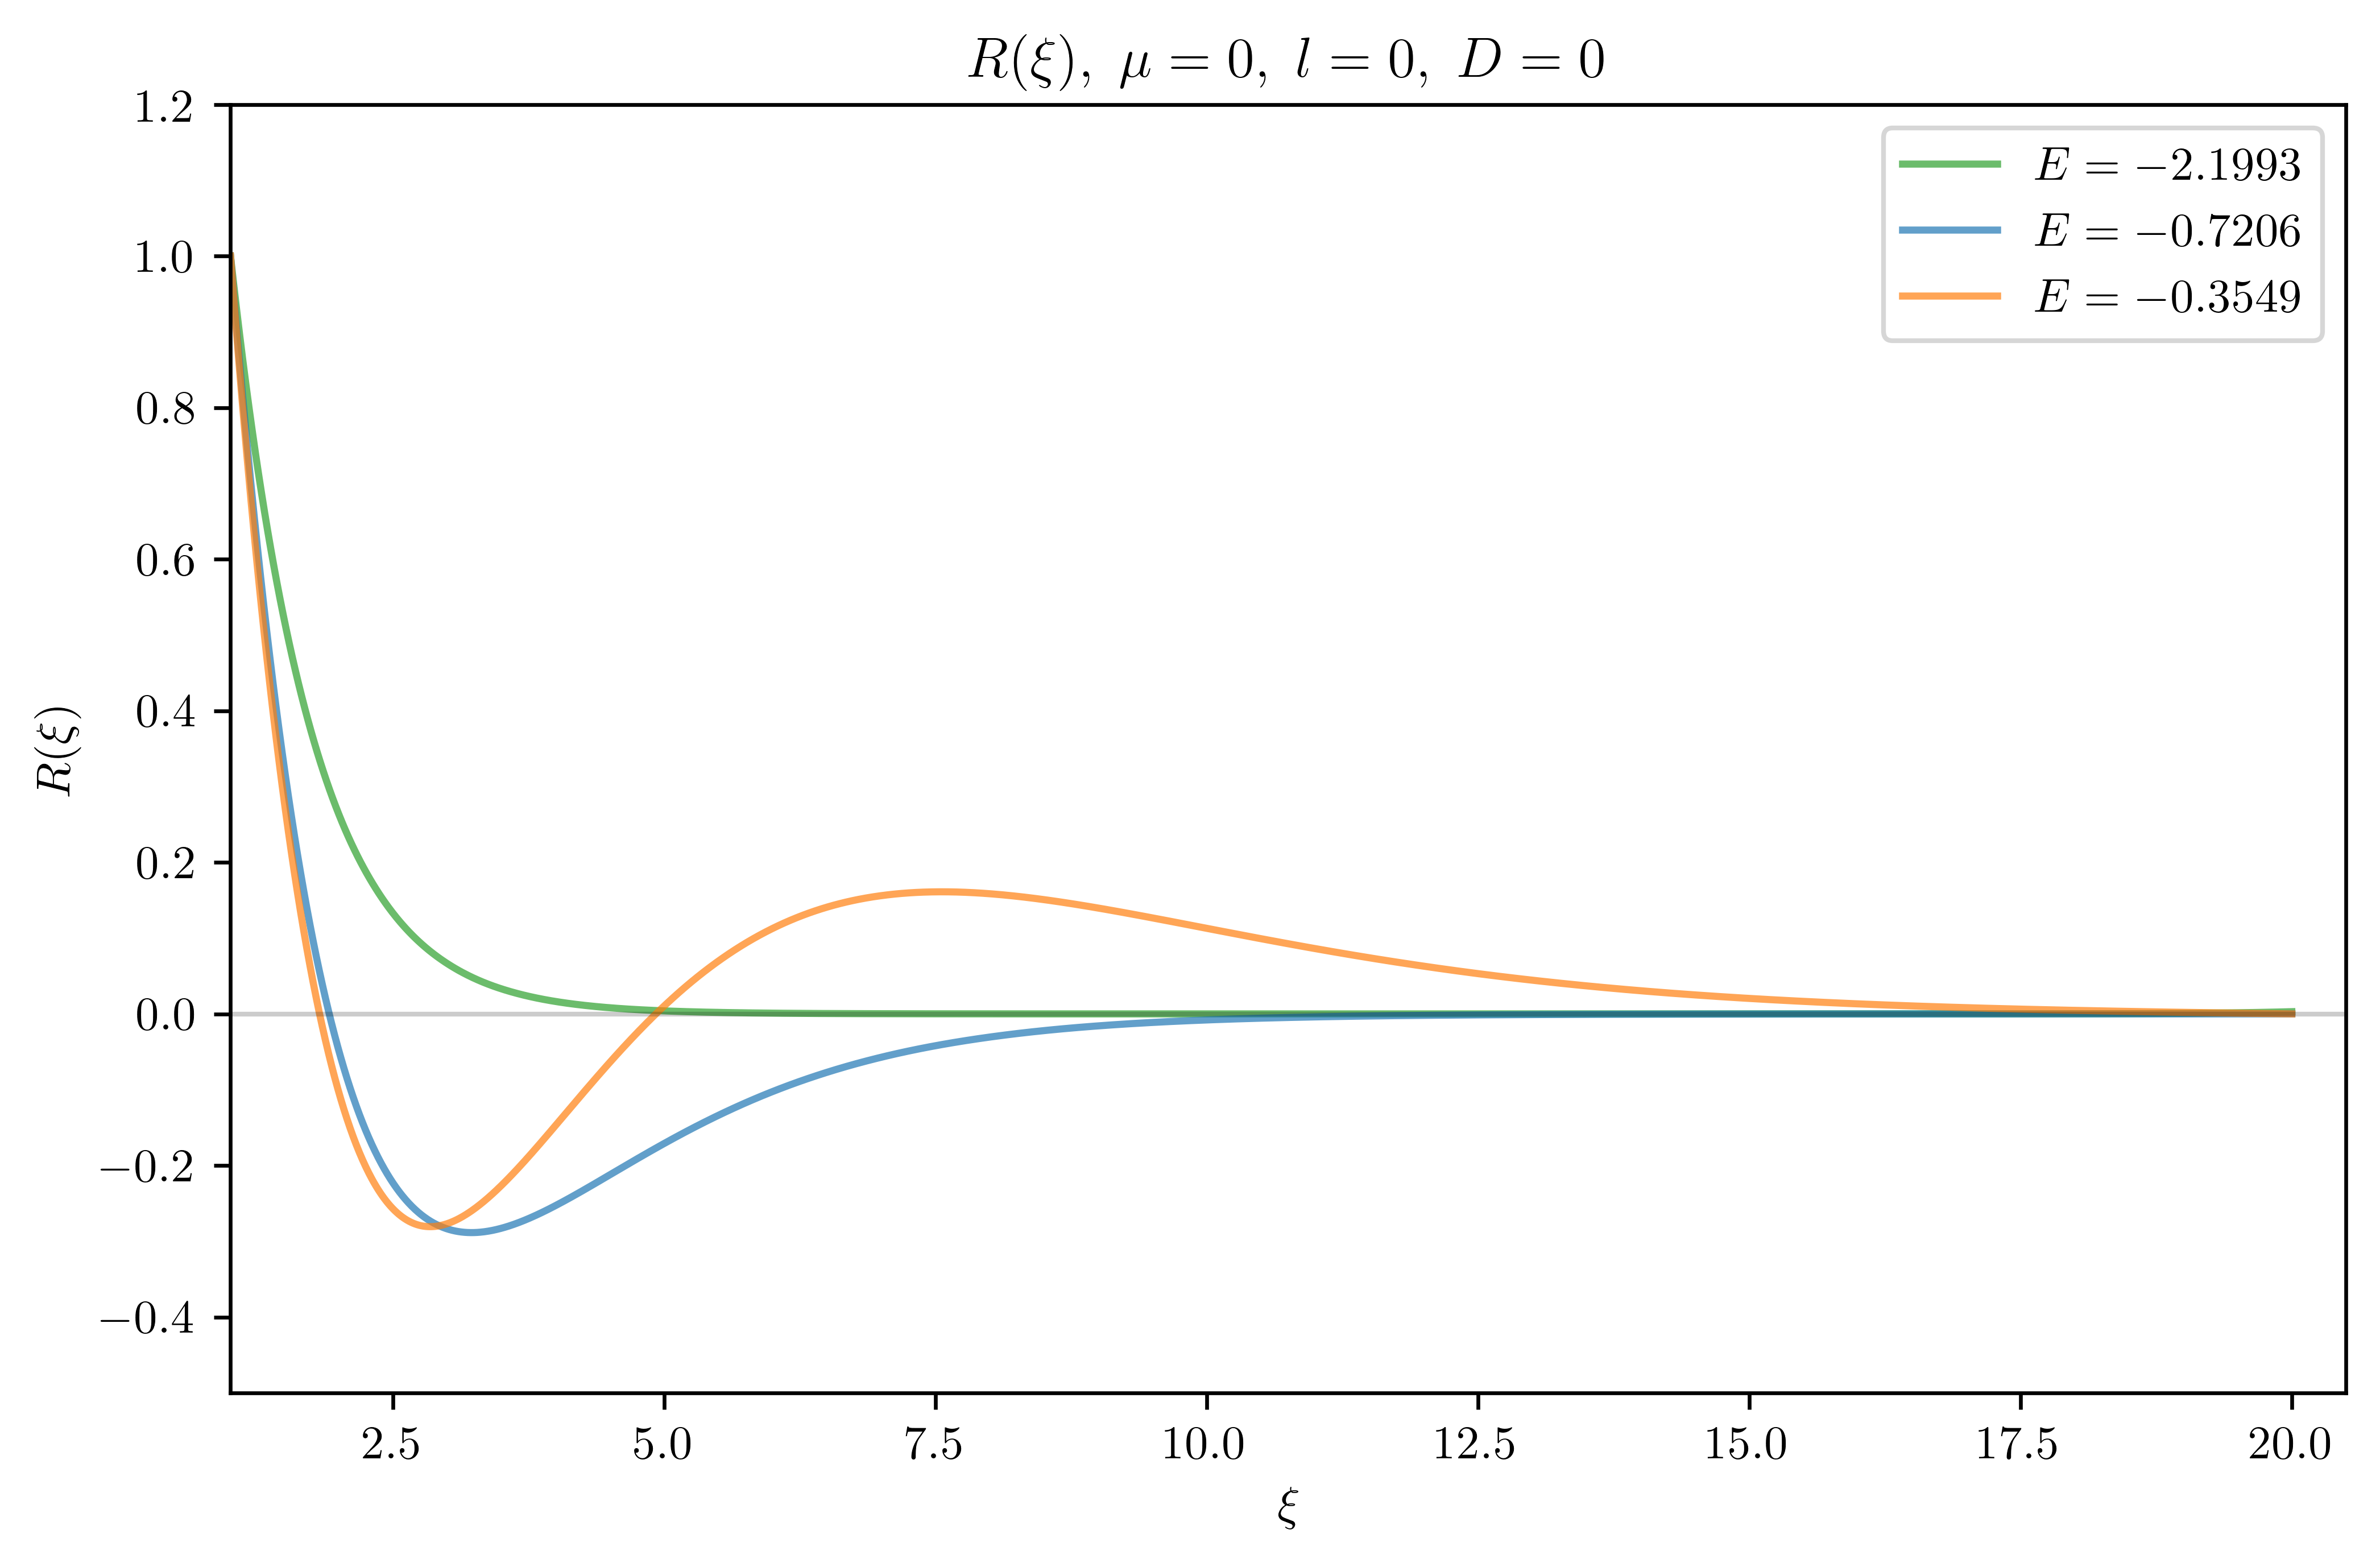

In [2]:
fig, ax = plt.subplots()

# greater cutoff value for higher energy states
cutoff = 20
xi_span = np.linspace(1, cutoff, cutoff*100)

color = ['C2', 'C0', 'C1']

for ind, E_val_guess in enumerate([-2.20, -0.72, -0.35]):
    E_val_final, = fsolve(objective, E_val_guess)

    R_vals = calculate_R(mu, l, E_val_final, lbda, cutoff=cutoff)

    E_val_label = f'$E = {E_val_final:.4f}$'
    ax.plot(xi_span, R_vals, label=E_val_label, color=color[ind], alpha=0.7)
    ax.set_title(r'$R(\xi), \; \mu = 0, \; l = 0, \; D = 0$')
    ax.legend()
    ax.set_ylim(-0.5, 1.2)
    ax.set_xlim(1, 20.5)

ax.axhline(y=0, color='k', alpha=0.2, linewidth=1)
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$R(\xi)$');

Notice that # nodes increases by 1 -> n = 1, thus n - 1 radial nodes

misconception: n is not number.

### Before calculating the actual wavefunctions

We fixed D, in a way D is a parameter. 

Vary D to vary E

